# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

    100% |████████████████████████████████| 14.6MB 43kB/s  eta 0:00:01   13% |████▎                           | 2.0MB 10.7MB/s eta 0:00:02    51% |████████████████▌               | 7.5MB 27.8MB/s eta 0:00:01    71% |██████████████████████▉         | 10.4MB 28.0MB/s eta 0:00:01
  Found existing installation: matplotlib 2.1.0
    Uninstalling matplotlib-2.1.0:
      Successfully uninstalled matplotlib-2.1.0
You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

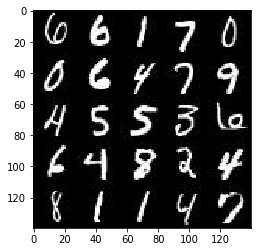

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

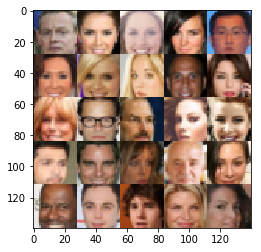

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(dtype=tf.float32, shape=(None, image_width, image_height, image_channels), name="real_input")
    z_input = tf.placeholder(dtype=tf.float32, shape=(None, z_dim), name="z_input")
    learn_rate = tf.placeholder(dtype=tf.float32, shape=(), name="learn_rate")

    return (real_input, z_input, learn_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [27]:
def discriminator(images, reuse=False, alpha=0.1):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    # AE: Assuming that we'll be passing in data through the "real_input" placeholder created in the "model_inputs" above.
    # AE: In that case "images" will have this shape: shape=(None, image_width, image_height, image_channels).
    # AE: We know that both image_width=28 and image_height=28
    
    with tf.variable_scope('discriminator', reuse=reuse):    
        # AE: Let's try a convolution layer with 32 filters to start with, kernel of 3x3, strides=2x2 and ReLU activation 
        # AE: function. Image is now 28x28x3 and we'll convert it to 14x14x32
        c1 = tf.contrib.layers.conv2d(inputs=images, num_outputs=32, kernel_size=3, stride=2, padding='SAME', 
                                      activation_fn=None)
        # AE: Don't apply batch normalisation on the first convolutional layer in discriminator, they said.
        #c1 = tf.layers.batch_normalization(inputs=c1, momentum=0.99, epsilon=0.001, training=True)

        # AE: Applying leaky relu
        c1 = tf.maximum(c1 * alpha, c1)

        # AE: Input is now 14x14x32 and we'll convert it to 7x7x64
        c2 = tf.contrib.layers.conv2d(inputs=c1, num_outputs=64, kernel_size=3, stride=2, padding='SAME', activation_fn=None) # activation_fn=tf.nn.relu
        c2 = tf.layers.batch_normalization(inputs=c2, momentum=0.99, epsilon=0.001, training=True)
        # AE: Applying leaky relu
        c2 = tf.maximum(c2 * alpha, c2)
        
        #print("C2 shape: ", c2.get_shape())
        
        # AE: Input is now 7x7x64 and we'll convert it to 3x3x128
        # AE: We'll be using padding='VALID' here to drop the remaining pixel when we want to downscale 7x7 image into
        # AE: a 3x3 one. That way the kernel window will ignore the last row and last column, instead of adding an extra
        # AE: one with a copy of the previous row and column.
        c3 = tf.contrib.layers.conv2d(inputs=c2, num_outputs=128, kernel_size=3, stride=2, padding='VALID', activation_fn=None) # activation_fn=tf.nn.relu
        c3 = tf.layers.batch_normalization(inputs=c3, momentum=0.99, epsilon=0.001, training=True)
        # AE: Applying leaky relu
        c3 = tf.maximum(c3 * alpha, c3)
        
        #print("C3 shape: ", c3.get_shape())
        
        # AE: Now let's flatten it and get a single result through a dense layer:
        c3 = tf.reshape(c3, (-1, 3 * 3 * 128))
        logits = tf.layers.dense(inputs=c3, units=1, activation=None, use_bias=True)
        
        output = tf.sigmoid(logits)
        
    
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

C2 shape:  (?, 7, 7, 64)
C3 shape:  (?, 3, 3, 128)
C2 shape:  (?, 7, 7, 64)
C3 shape:  (?, 3, 3, 128)
Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [28]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=(not is_train)):
        # AE: Let's start with a dense layer where we'll load in z and stretch it to a starting shape of 2x2x512
        fc = tf.layers.dense(inputs=z, units=512 * 2 * 2, activation=None, use_bias=True)

        # AE: Now turn it into the correct shape
        fc = tf.reshape(fc, [-1, 2, 2, 512])
        # AE: Now batch normalisation
        fcbn = tf.layers.batch_normalization(inputs=fc, momentum=0.99, epsilon=0.001, training=is_train)
        # AE: Leaky ReLU
        fcbnlr = tf.maximum(fcbn * alpha, fcbn)
        #print(fcbnlr.shape)

        # AE: And off we go with the convolutional transpose layers to downscale number of filters and make our picture emerge
        # AE: Our random values are now shaped: 2x2x512. Let's get them into 4x4x256
        ct1 = tf.contrib.layers.conv2d_transpose(inputs=fcbnlr, num_outputs=256, kernel_size=3, stride=2, 
                                                 padding='SAME', activation_fn=None) #data_format=DATA_FORMAT_NHWC, activation_fn=tf.nn.relu,
        # AE: Batch normalisation
        ct1bn = tf.layers.batch_normalization(inputs=ct1, momentum=0.99, epsilon=0.001, training=is_train)
        # AE: Leaky ReLU
        ct1bnlr = tf.maximum(ct1bn * alpha, ct1bn)
        
        #print(ct1bnlr.shape)
        
        # AE: 4x4x256 -> 8x8x128
        ct2 = tf.contrib.layers.conv2d_transpose(inputs=ct1bnlr, num_outputs=128, kernel_size=3, stride=2, 
                                                 padding='SAME', activation_fn=None)
        ct2bn = tf.layers.batch_normalization(inputs=ct2, momentum=0.99, epsilon=0.001, training=is_train)
        ct2bnlr = tf.maximum(ct2bn * alpha, ct2bn)
        
        #print(ct2bnlr.shape)

        # AE: 8x8x128 -> 16x16x64
        ct3 = tf.contrib.layers.conv2d_transpose(inputs=ct2bnlr, num_outputs=64, kernel_size=3, stride=2, 
                                                 padding='SAME', activation_fn=None)
        ct3bn = tf.layers.batch_normalization(inputs=ct3, momentum=0.99, epsilon=0.001, training=is_train)
        ct3bnlr = tf.maximum(ct3bn * alpha, ct3bn)
        
        #print(ct3bnlr.shape)

        # AE: 16x16x128 -> 32x32x3 (or 32x32x1 in case of MNIST)
        ct4 = tf.contrib.layers.conv2d_transpose(inputs=ct3bnlr, num_outputs=out_channel_dim, kernel_size=3, stride=2, 
                                                 padding='SAME', activation_fn=None)
        
        # AE: now we have 32x32x3 shape, but we want 28x28x3. We could flatten, then drop values from the tail, then 
        # AE: reshape back, but that would brutally change the content of the dimensions. Maybe instead we could 
        # AE: carefully carve out what we want through slicing. And of course we want tanh activation.
        output = tf.tanh(ct4)
        output = output[:, :28, :28, :]
        #output_flattened = tf.flatten(output)
        #print(output.shape, " out_channel_dim=", out_channel_dim)
        
        #print("0: ", output[0][0][0].shape, "1: ", output[1].shape, "2: ", output[2].shape, "3: ", output[3].shape)
        #print("0: ", output[28:][28:][0])
        #print("0ut: ", output[:, :28, :28, :])
        
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [29]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    # AE: In essence we want to create a generator and discriminator, then feed the input_z to the generator,
    # AE: then feed generator's output to the discriminator, then the output of the disciminator (assuming 1 means
    # AE: natural picture and 0-artificial) is discriminator's loss. Generator's loss is discriminator's output 
    # AE: subtracted from 1. Discriminator should also be tested against the real image and its result subtracted from
    # AE: 1. That will be discrimantor's loss for real images. Both discriminator's losses need to be summed to take both 
    # AE: of them into account (should they be aggregated?).
    # AE:
    # AE: We want generator to NOT re-use the variables, because ... not sure?? ... so setting is_train=True.
    g = generator(input_z, out_channel_dim, is_train=True)
    # AE: The first discriminator should NOT re-use variables, because they have not been set up yet.
    d_artificial, d_a_logits = discriminator(g, reuse=False)
    # AE: The second discriminator SHOULD re-use variables from the first discriminator 
    d_real, d_r_logits = discriminator(input_real, reuse=True)
    

    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_a_logits, labels=tf.zeros_like(d_artificial)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_a_logits, labels=tf.ones_like(d_artificial)))
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_r_logits, labels=tf.ones_like(d_real)))

    d_loss = d_loss_real + d_loss_fake

    #g_loss = 1 - d_a_logits
    #d_loss = d_a_logits + (1 - d_r_logits)
    
    return (d_loss, g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

C2 shape:  (?, 7, 7, 64)
C3 shape:  (?, 3, 3, 128)
C2 shape:  (?, 7, 7, 64)
C3 shape:  (?, 3, 3, 128)
Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [30]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # AE: Let's use Adam optimiser on the loss that we calculated earlier and let the optimiser change the variables
    # AE: that we get from tf.trainable_variables
    all_vars = tf.trainable_variables()
    d_vars = [var for var in all_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in all_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)

    return (d_opt, g_opt)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [31]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [32]:
# AE: To implement train method, I need to know for sure how the datasets look like.

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
print("MNIST shape and mode: ", mnist_dataset.shape, mnist_dataset.image_mode)

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
print("CELEBA shape and mode: ", celeba_dataset.shape, celeba_dataset.image_mode)

MNIST shape and mode:  (60000, 28, 28, 1) L
CELEBA shape and mode:  (202599, 28, 28, 3) RGB


In [33]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    img_width = data_shape[1]
    img_height = data_shape[2]
    out_channel_dim = data_shape[3]

    # AE: placeholders, which we'll change when training (feed into the TF session)
    real_input, z_input, learn_rate = model_inputs(img_width, img_height, out_channel_dim, z_dim)

    # AE: And now the model taking in the placeholders
    d_loss, g_loss = model_loss(real_input, z_input, out_channel_dim)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)

    # AE: number of batches pushed through our model
    batches_pushed = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                # AE: We have a batch of real images in the batch_images, but we also need a batch of random vectors
                # AE: to give to the generator. Both batches of course need to be the same size.
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # AE: Now we can run generator and discriminator in the TF session, passing in the pictures and the random
                # AE: vectors, then evaluating loss, optimising and training
                _ = sess.run(g_opt, feed_dict={z_input: batch_z, real_input: batch_images, learn_rate: learning_rate})
                _ = sess.run(d_opt, feed_dict={real_input: batch_images, z_input: batch_z, learn_rate: learning_rate})

                # AE: Every 10 batches we can print out training statistics
                if (batches_pushed != 0 and batches_pushed % 10 == 0):
                    print("AAAA")
                    train_loss_g = g_loss.eval(feed_dict={z_input: batch_z, real_input: batch_images, learn_rate: learning_rate})
                    train_loss_d = d_loss.eval(feed_dict={z_input: batch_z, real_input: batch_images, learn_rate: learning_rate})

                    print("Epoch {}/{}...".format(epoch_i + 1, epoch_count), " D loss: {:.4f}".format(train_loss_d),
                         " G loss: {:.4f}".format(train_loss_g))

                # AE: And every 100 batches we could show the images that we can now generate
                if (batches_pushed != 0 and batches_pushed % 20 == 0):
                    show_generator_output(sess=sess, n_images=10, input_z=z_input, 
                                          out_channel_dim=out_channel_dim, image_mode=data_image_mode)
                
                # AE: Another batch has been pushed through our model
                batches_pushed += 1

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

C2 shape:  (?, 7, 7, 64)
C3 shape:  (?, 3, 3, 128)
C2 shape:  (?, 7, 7, 64)
C3 shape:  (?, 3, 3, 128)
AAAA
Epoch 1/10...  D loss: 0.2571  G loss: 4.9550
AAAA
Epoch 1/10...  D loss: 0.1546  G loss: 5.5299


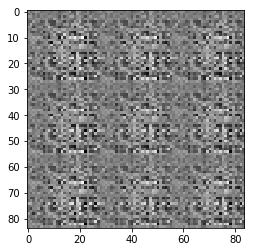

KeyboardInterrupt: 

In [34]:
batch_size = 50
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 10

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

AAAA
Epoch 1/2...  D loss: 1.2675  G loss: 0.8838
AAAA
Epoch 1/2...  D loss: 1.0234  G loss: 1.1064


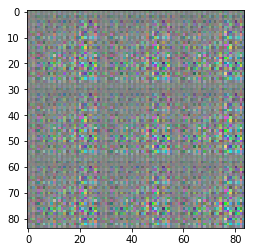

AAAA
Epoch 1/2...  D loss: 0.8339  G loss: 1.3834
AAAA
Epoch 1/2...  D loss: 0.7884  G loss: 1.3947


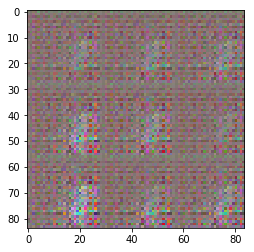

AAAA
Epoch 1/2...  D loss: 0.8716  G loss: 1.2232
AAAA
Epoch 1/2...  D loss: 0.7414  G loss: 1.3912


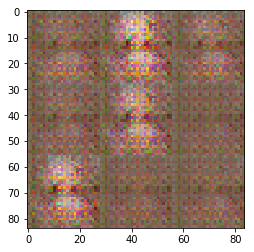

AAAA
Epoch 1/2...  D loss: 0.7665  G loss: 1.5986
AAAA
Epoch 1/2...  D loss: 0.6088  G loss: 1.3980


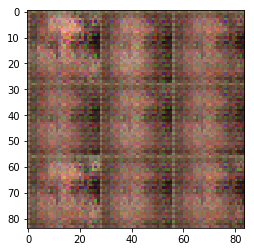

AAAA
Epoch 1/2...  D loss: 0.5706  G loss: 2.0119
AAAA
Epoch 1/2...  D loss: 0.8236  G loss: 2.0565


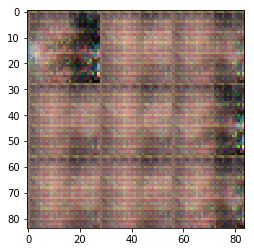

AAAA
Epoch 1/2...  D loss: 0.5941  G loss: 1.4383
AAAA
Epoch 1/2...  D loss: 0.7103  G loss: 1.6196


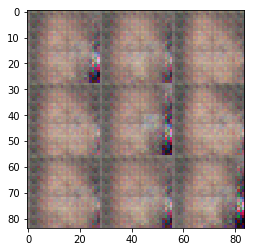

AAAA
Epoch 1/2...  D loss: 1.0246  G loss: 1.2773
AAAA
Epoch 1/2...  D loss: 0.9897  G loss: 1.1804


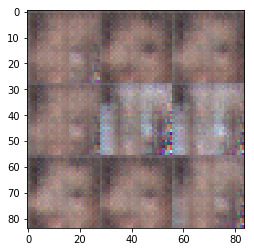

AAAA
Epoch 1/2...  D loss: 1.1894  G loss: 1.0170
AAAA
Epoch 1/2...  D loss: 1.2241  G loss: 0.9783


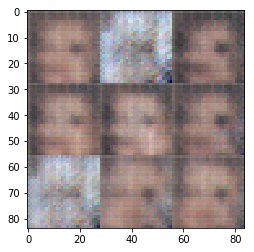

AAAA
Epoch 1/2...  D loss: 1.1772  G loss: 0.9632
AAAA
Epoch 2/2...  D loss: 1.1152  G loss: 0.9971


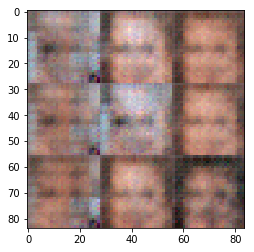

AAAA
Epoch 2/2...  D loss: 1.2506  G loss: 0.9695
AAAA
Epoch 2/2...  D loss: 1.2480  G loss: 0.8521


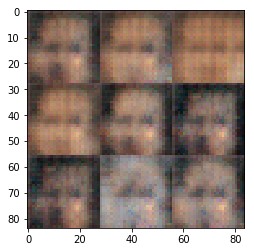

AAAA
Epoch 2/2...  D loss: 1.2530  G loss: 0.9320
AAAA
Epoch 2/2...  D loss: 1.3142  G loss: 0.7698


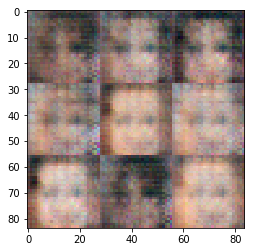

AAAA
Epoch 2/2...  D loss: 1.2019  G loss: 0.8877
AAAA
Epoch 2/2...  D loss: 1.2435  G loss: 0.8926


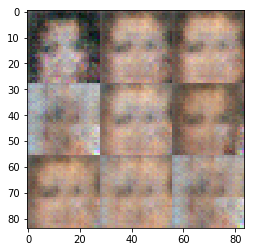

AAAA
Epoch 2/2...  D loss: 1.1770  G loss: 0.9986
AAAA
Epoch 2/2...  D loss: 1.2271  G loss: 0.9507


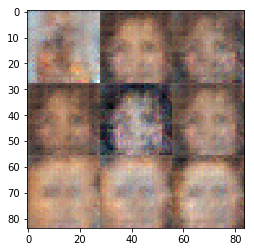

AAAA
Epoch 2/2...  D loss: 1.2152  G loss: 0.9691
AAAA
Epoch 2/2...  D loss: 1.1772  G loss: 0.9083


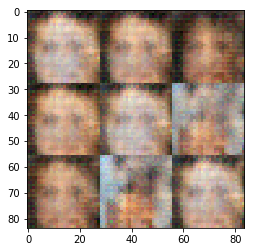

AAAA
Epoch 2/2...  D loss: 1.1448  G loss: 0.9284
AAAA
Epoch 2/2...  D loss: 1.0431  G loss: 1.1985


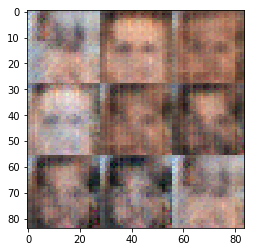

AAAA
Epoch 2/2...  D loss: 1.0501  G loss: 1.1524
AAAA
Epoch 2/2...  D loss: 1.1843  G loss: 1.0357


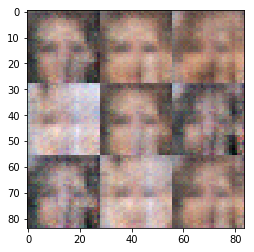

AAAA
Epoch 2/2...  D loss: 1.1145  G loss: 1.0775
AAAA
Epoch 2/2...  D loss: 1.0627  G loss: 0.9354


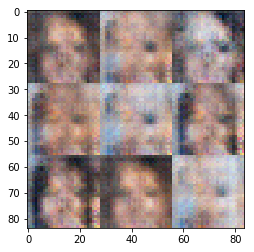

In [16]:
batch_size = 1152
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.